In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [112]:
data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We observe a threshold effect in high-valued houses, where all homes priced above $500,000 are capped at a value of $500,000.


We will reduce distribution skewness by applying the log(x+1) transformation later.

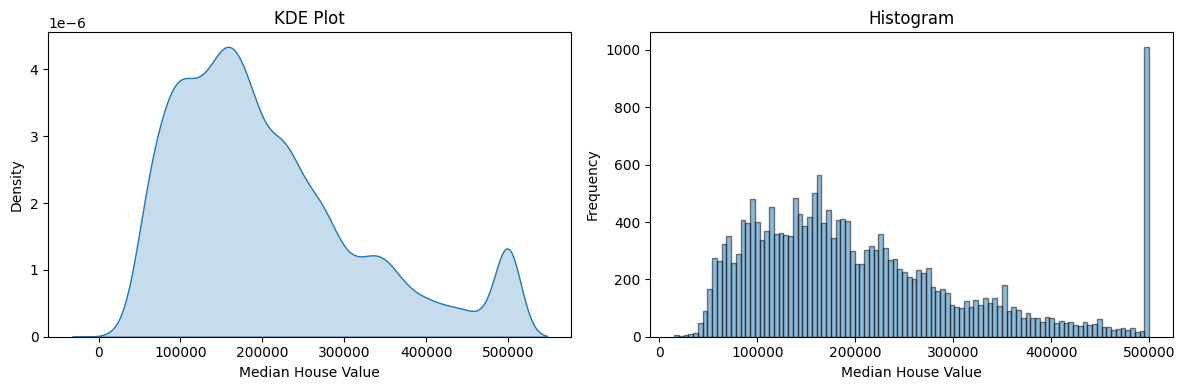

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(data['median_house_value'], fill=True, ax=axes[0])
axes[0].set_xlabel('Median House Value')
axes[0].set_ylabel('Density')
axes[0].set_title('KDE Plot')

axes[1].hist(data['median_house_value'], bins=100, edgecolor='k', alpha=0.5)
axes[1].set_xlabel('Median House Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram')

plt.tight_layout()
plt.show()

In [114]:
colomns_to_use = [  
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
    ]

In [115]:
data = data[colomns_to_use]

# Question 1
There's one feature with missing values. What is it?

In [116]:
missing_values = data.isna().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
total_bedrooms    207
dtype: int64


# Question 2
What's the median (50% percentile) for variable 'population'?

In [117]:
data['population'].median()

1166.0

# Prepare and split the dataset
* Shuffle the initial dataset, use seed 42.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [118]:
data['median_house_log_value'] = data['median_house_value'].map(lambda x: np.log1p(x))

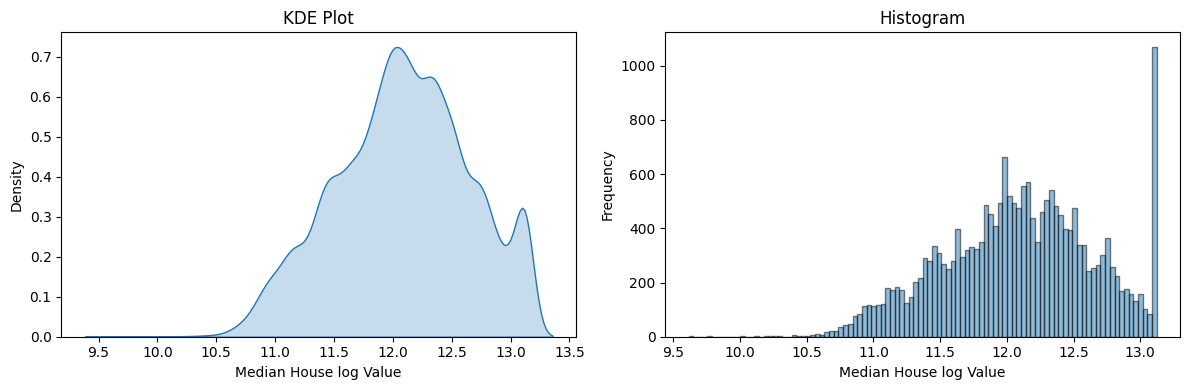

In [119]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.kdeplot(data['median_house_log_value'], fill=True, ax=axes[0])
axes[0].set_xlabel('Median House log Value')
axes[0].set_ylabel('Density')
axes[0].set_title('KDE Plot')

axes[1].hist(data['median_house_log_value'], bins=100, edgecolor='k', alpha=0.5)
axes[1].set_xlabel('Median House log Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram')

plt.tight_layout()
plt.show()

In [120]:
data_shuffled = data.sample(frac=1.0, random_state=42)

In [121]:
train, val_test = train_test_split(data_shuffled, test_size=0.4)
val, test = train_test_split(val_test, test_size=0.5)

In [122]:
missing_values = train.isna().sum()
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
total_bedrooms    125
dtype: int64


# Question 3
* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using round(score, 2)
* Which option gives better RMSE?

In [123]:
avg_total_bedrooms = train['total_bedrooms'].mean()
avg_total_bedrooms

539.1305979280529

In [124]:
train['total_bedrooms_zero_inputation'] = train['total_bedrooms']
train['total_bedrooms_zero_inputation'].fillna(0.0, inplace=True)
train['total_bedrooms_mean_inputation'] = train['total_bedrooms']
train['total_bedrooms_mean_inputation'].fillna(avg_total_bedrooms, inplace=True)


val['total_bedrooms_zero_inputation'] = val['total_bedrooms']
val['total_bedrooms_zero_inputation'].fillna(0.0, inplace=True)
val['total_bedrooms_mean_inputation'] = val['total_bedrooms']
val['total_bedrooms_mean_inputation'].fillna(avg_total_bedrooms, inplace=True)


test['total_bedrooms_zero_inputation'] = test['total_bedrooms']
test['total_bedrooms_zero_inputation'].fillna(0.0, inplace=True)
test['total_bedrooms_mean_inputation'] = test['total_bedrooms']
test['total_bedrooms_mean_inputation'].fillna(avg_total_bedrooms, inplace=True)

In [125]:
colomns_to_use_zero_inputation = [  
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms_zero_inputation',
    'population',
    'households',
    'median_income',
    ]

colomns_to_use_mean_inputation = [  
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms_mean_inputation',
    'population',
    'households',
    'median_income',
    ]

In [126]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [127]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [128]:
def viz(y_pred, y_val):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    sns.kdeplot(y_pred, color='red', fill=True, ax=axes[0])
    sns.kdeplot(y_val, color='blue', fill=True, ax=axes[0])
    axes[0].set_xlabel('Median House log Value')
    axes[0].set_ylabel('Density')
    axes[0].set_title('KDE Plot')


    sns.histplot(y_pred, color='red', alpha=0.5, bins=100, ax=axes[1])
    sns.histplot(y_val, color='blue', alpha=0.5, bins=100,  ax=axes[1])
    axes[1].set_xlabel('Median House log Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Histogram')

    legend_labels = ['y_pred', 'y_val']
    legend_handles = [plt.Line2D([0], [0], color='red', lw=2),
                    plt.Line2D([0], [0], color='blue', lw=2)]
    fig.legend(legend_handles, legend_labels, loc='upper right')

    plt.tight_layout()
    plt.show()

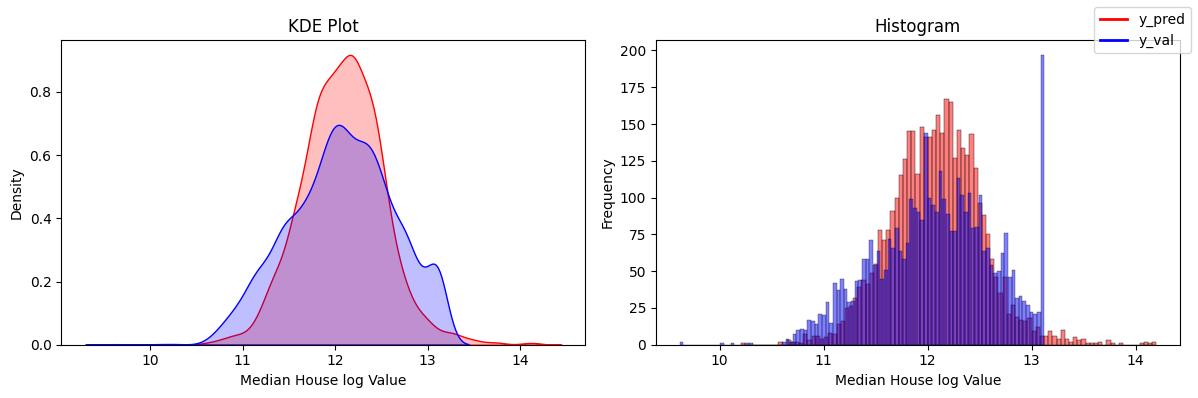

The RMSE val score is 0.3320868323150282


In [129]:
X_tr_0 = train[colomns_to_use_zero_inputation].values
y_tr = train['median_house_log_value']

w0, w = train_linear_regression(X_tr_0, y_tr)

X_val_0 = val[colomns_to_use_zero_inputation].values
y_val = val['median_house_log_value']
y_pred = w0 + X_val_0.dot(w)

viz(y_pred, y_val)
score = rmse(y_val, y_pred)
print(f'The RMSE val score is {score}')

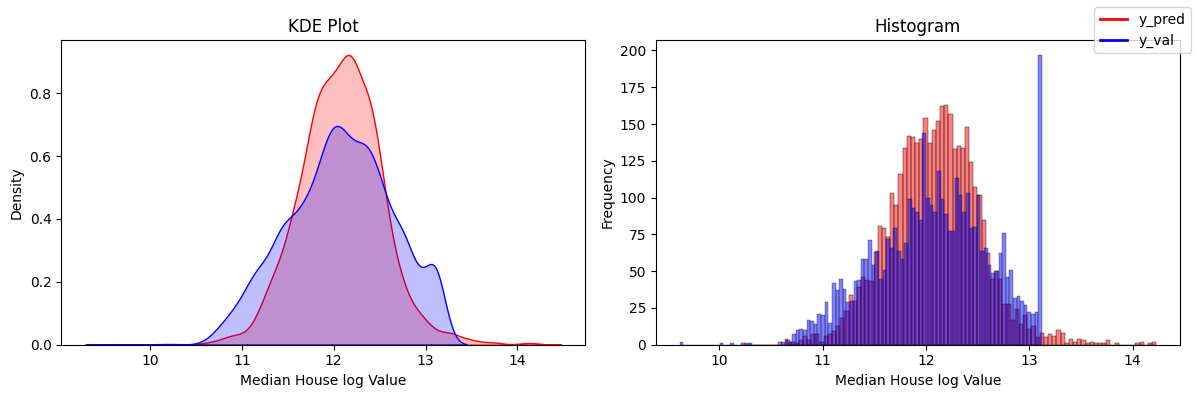

The RMSE val score is 0.3313922901361619


In [130]:
X_tr_avg = train[colomns_to_use_mean_inputation].values
y_tr = train['median_house_log_value']

w0, w = train_linear_regression(X_tr_avg, y_tr)

X_val_avg = val[colomns_to_use_mean_inputation].values
y_val = val['median_house_log_value']
y_pred = w0 + X_val_avg.dot(w)

viz(y_pred, y_val)
score = rmse(y_val, y_pred)
print(f'The RMSE val score is {score}')

# Question 4
* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0.
* Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which r gives the best RMSE?

In [131]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [132]:
penalties = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

for penalty in penalties:

    w0, w = train_linear_regression_reg(X_tr_0, y_tr, r=penalty)

    y_pred = w0 + X_val_0.dot(w)

    score = rmse(y_val, y_pred)
    print(round(score, 2), penalty)

0.33 0
0.33 1e-06
0.33 0.0001
0.33 0.001
0.33 0.01
0.33 0.1
0.34 1
0.34 5
0.34 10


# Question 5
* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
* What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
* Round the result to 3 decimal digits (round(std, 3))

In [133]:
def split(random_seed):
    data_shuffled = data.sample(frac=1.0, random_state=random_seed)
    data_shuffled['total_bedrooms_zero_inputation'] = data_shuffled['total_bedrooms']
    data_shuffled['total_bedrooms_zero_inputation'].fillna(avg_total_bedrooms, inplace=True)
    train, val_test = train_test_split(data_shuffled, test_size=0.4)
    val, test = train_test_split(val_test, test_size=0.5)
    return train, val, test

In [134]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# seed_values = range(200)
scores = []
for seed in seed_values:
    train, val, test = split(seed)

    X_tr_0 = train[colomns_to_use_zero_inputation].values
    y_tr = train['median_house_log_value']

    w0, w = train_linear_regression(X_tr_0, y_tr)

    X_val_0 = val[colomns_to_use_zero_inputation].values
    y_val = val['median_house_log_value']
    y_pred = w0 + X_val_0.dot(w)

    score = rmse(y_val, y_pred)
    scores.append(round(score, 3))

std_deviation = np.std(scores)
std_deviation

0.006177378084592184

In [135]:
scores

[0.346, 0.341, 0.335, 0.348, 0.342, 0.342, 0.348, 0.336, 0.33, 0.35]

# Question 6
* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with r=0.001.
* What's the RMSE on the test dataset?

In [136]:
train, val, test = split(9)

combined = pd.concat([train, val], axis=0)

X_tr_0 = combined[colomns_to_use_zero_inputation].values
y_tr = combined['median_house_log_value']

w0, w = train_linear_regression_reg(X_tr_0, y_tr, r=0.001)

X_test_0 = test[colomns_to_use_zero_inputation].values
y_test = test['median_house_log_value']
y_pred = w0 + X_test_0.dot(w)

score = rmse(y_test, y_pred)
score

0.3388986418902019